In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statistics
import os
from sklearn.model_selection import KFold,cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb

#Pulling data
Data_path = 'C:/Users/Imran/Documents/Data Science/Projects/Titanic/'
Train_df = pd.read_csv(Data_path + 'train.csv')
Test_df = pd.read_csv(Data_path + 'test.csv')

#Combining both datasets, this allows for both datasets to analyzed and manipulated together
Train_df['Dataset'] = 1
Test_df['Dataset'] = 0
Combined_df = Train_df.append(Test_df,sort=False)

<br>**Lets start by reviewing the feature details:**

<br>**Passenger ID**:     A unique passenger ID number from 1-891
<br>**Survived**:  	    1 = survived, 0 = didn't survive
<br>**Social Class**:     A measure social of status (1 = Upper Class, 2 = Middle, 3 = Lower)
<br>**Name**:     	    Name of the passenger
<br>**Gender**:    	    Male or Female
<br>**Age**:      	    Age in years
<br>**Sib/Spouse**: 	    The number of siblings or spouses the passenger had on board
<br>**Parents/children**: The number of parents or children the passenger had on board
<br>**Ticket**:   	    Ticket number/code
<br>**Fare**:     	    Price paid for the ticket
<br>**Cabin**:    	    Code of the Cabin the passenger was staying in
<br>**Embarked**: 	    Port on which they boarded the titanic (C = Cherbourg, Q = Queenstown, S = Southampton)

<br>**First Parameters to drop are:
<br>**Passenger Id** – Just a unique number (1,2,3)
<br>**Name** –         We can’t use this to classify or group the passenger.
<br>**Ticket** –       Random combination of letters and numbers (A/5 21171, PC 17599)
<br>**Cabin** –        Letter and number combination(C85, C123)

In [6]:
Combined_df = Combined_df.drop(['PassengerId','Name','Ticket','Cabin'],axis=1)

<br>**Checking for Missing data**

In [7]:
Combined_df.isnull().sum()

Survived    418
Pclass        0
Sex           0
Age         263
SibSp         0
Parch         0
Fare          1
Embarked      2
Dataset       0
dtype: int64

<br>Age, Fare and Embarked have missing values, these will be dealt with by:
<br>Age & Fare: Filling blanks with the average age of the sample
<br>Embarked: Fill with the most common value

In [8]:
Combined_df['Age'] = Combined_df['Age'].fillna(np.mean(Combined_df['Age']))
Combined_df['Fare'] = Combined_df['Fare'].fillna(np.mean(Combined_df['Fare']))
Combined_df['Embarked'] = Combined_df['Embarked'].fillna(statistics.mode(Combined_df['Embarked']))

<br>Rechecking for Missing data

In [9]:
Combined_df.isnull().sum()

Survived    418
Pclass        0
Sex           0
Age           0
SibSp         0
Parch         0
Fare          0
Embarked      0
Dataset       0
dtype: int64

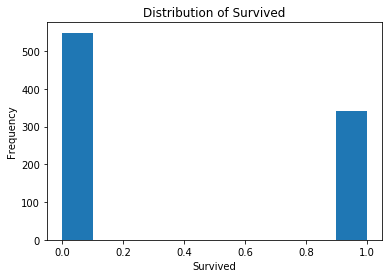

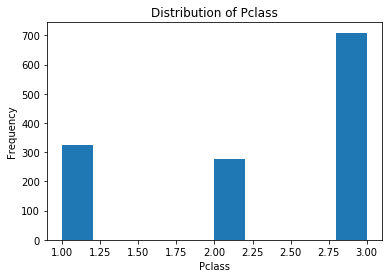

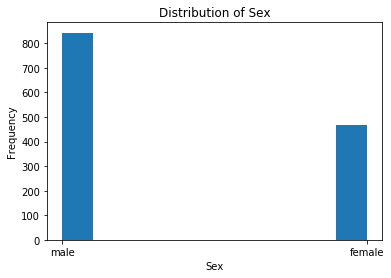

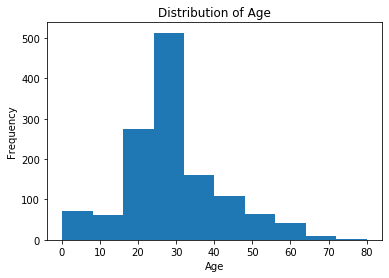

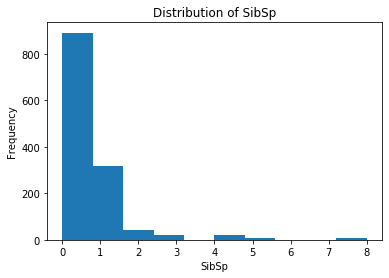

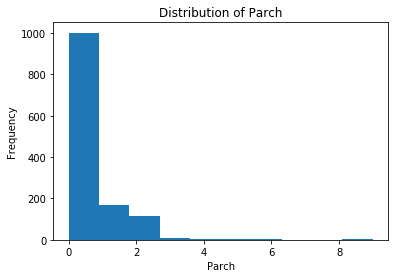

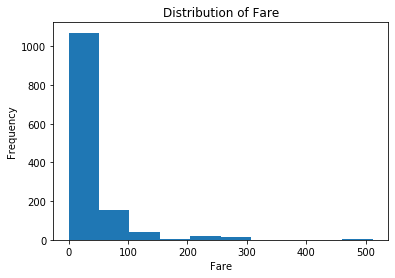

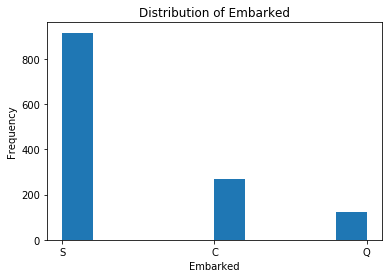

In [10]:
for feature in Combined_df:
    if feature != 'Dataset':
        if feature == 'Survived':
            plt.hist(Combined_df[feature][Combined_df['Survived'].notnull()])
        else:
            plt.hist(Combined_df[feature])
        plt.title('Distribution of {}'.format(feature))
        plt.ylabel('Frequency')
        plt.xlabel(feature)
        plt.show()

**Initial thoughts on feature distribution:**
<br>**Survived:**  	    38% of passengers in the training dataset survived
<br>**Social Class:**   The majority of passengers where of lower social status, while there was an equal spread between middle and upper class
<br>**Gender:**    	    64% of passengers were male
<br>**Age:**      	    Distribution of age generally follows a normal distribution with a right skew
<br>**Sib/Spouse:** 	    The majority of passengers were travelling without siblings, the largest group size was 8
<br>**Parents/children:** The majority of passengers were travelling without parents or children, the largest group size was 6
<br>**Fare:**     	    The majority of fares were under 50 (assuming local currency or all have been converted), with a few premium tickets, the highest was 512
<br>**Embarked:** 	    The majority of passengers embarked at Southampton


<br>Now looking at survival rates by each feature

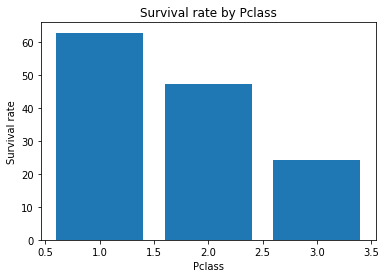

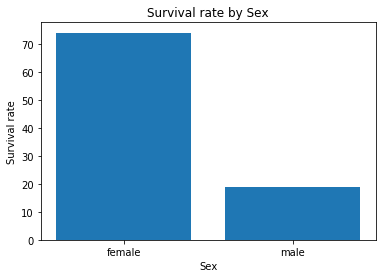

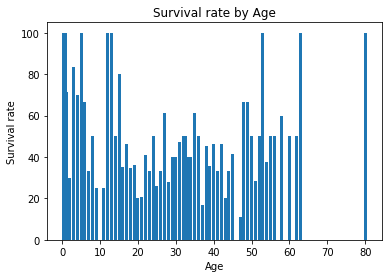

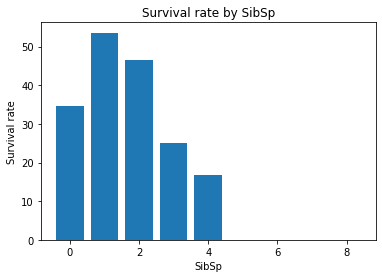

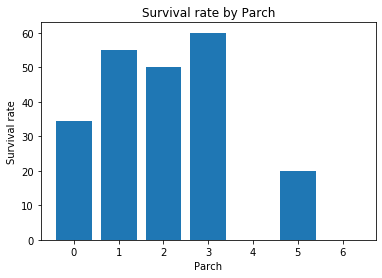

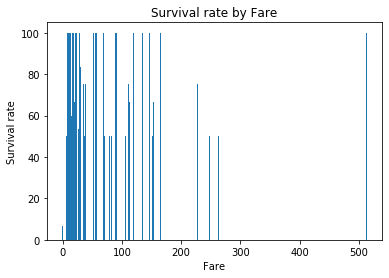

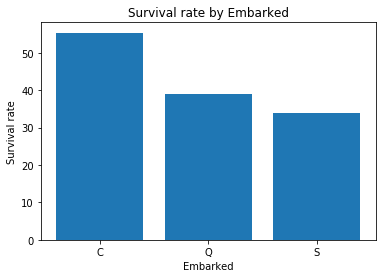

In [11]:
plt.clf()
for feature in Combined_df[Combined_df['Survived'].notnull()]:
    if feature not in ['Survived','Dataset']:
        Chart_df = Combined_df[Combined_df['Survived'].notnull()][[feature,'Survived']].groupby(feature).agg(np.mean)
        Chart_df.reset_index(inplace = True)
        Chart_df['Survived'] = Chart_df['Survived']*100
        plt.bar(Chart_df[feature],Chart_df['Survived'])
        plt.title('Survival rate by {}'.format(feature))
        plt.ylabel('Survival rate')
        plt.xlabel(feature)
        plt.show()

<h1>Model Building</h1>
<br>We'll now start the model building process. Before beginning we'll need to clean up the data.
<br>Transformation notes:
<br>Social Class,Sib/Spouse and Parents/children have been left as they are (numerical values from 0-9)
<br>Age has been split into 6 intervals and assigned values from 0-5
<br>Gender has been mapped to 0 for Males and 1 for Females
<br>Fare has been split into 8 intervals and assigned values from 0-7
<br>Embarked will be split into one column per location

In [12]:
Combined_df['Age'] = pd.qcut(Combined_df['Age'], q=6,labels=list(range(0,6))).astype('int')
Combined_df['Sex'] = Combined_df['Sex'].map({'male':0,'female':1})
Combined_df['Fare'] = pd.qcut(Combined_df['Fare'], q=8,labels=list(range(0,8))).astype('int')
Combined_df = pd.get_dummies(Combined_df,columns=['Embarked'])

<br>**Model Selection:**
<br>We'll now start the process of building our model. Firstly we'll fit a model using all available features to get a baseline measure of accuracy

In [13]:
Train_df = Combined_df[Combined_df['Dataset']==1].drop('Dataset',axis=1)
Test_df = Combined_df[Combined_df['Dataset']==0].drop(['Dataset','Survived'],axis=1)

X_train = Train_df.drop('Survived',axis=1)
Y_train = Train_df['Survived']

Algorithms = [LogisticRegression(),KNeighborsClassifier(n_neighbors = 3),GaussianNB(),Perceptron(),LinearSVC(max_iter = 4000),RandomForestClassifier(n_estimators=100),DecisionTreeClassifier()]
#Scoring will be done using 5-fold cross validation
def produce_scoring_grid(Algorithms,X_train,Y_train):
    Algorithm_Labels = [str(x).split('(')[0] for x in Algorithms]
    Results = []
    kf = KFold(5,shuffle = True,random_state = 42).get_n_splits(X_train.values)
    for Algo in Algorithms:
        range_score = cross_val_score(Algo,X_train.values,Y_train,scoring = 'accuracy',cv=kf)
        Results.append(round(range_score.mean()*100,2))
    Results_df = pd.DataFrame(list(zip(Algorithm_Labels,Results)),columns = ['Algorithm','Score']).sort_values('Score',ascending = False)
    return Results_df

produce_scoring_grid(Algorithms,X_train,Y_train)

,Algorithm,Score
5,RandomForestClassifier,79.02
4,LinearSVC,79.01
0,LogisticRegression,78.34
6,DecisionTreeClassifier,77.90
1,KNeighborsClassifier,75.76
3,Perceptron,75.20
2,GaussianNB,74.98


Accuracy is currently around 76-80% for most algorithms with Random Forest performing the best.

<br>**Model Refinement:**
Now that we've established a base working model (with around 80% accuracy) we can now go about fine tuning our model for optimal performance, for this we'll evaluate 2 methods:
<br>**Feature engineering:**
Quite a few entries for this problem on Kaggle have engineered various features, such as attempting to pull a persons first and last name, given the features available and the minimal impact on survival rates, I don't personally believe that any additional features can be created.
<br>**Feature selection:**
The majority of Kaggle entries have included all features and simply allowed the ML algorithm to adjust around this, I believe this works fine for larger datasets, but for smaller datasets (the training set has 891 entries) any unnecessary features will simply introduce noise into the model, and hence reduce the accuracy
<br>From our earlier charts the 3 most significant features (in terms of influence on survival rates) were Social Class, Gender and Embarked, from running different simulations,these 3 features produced the greatest increase in accuracy from our base model:

In [14]:
produce_scoring_grid(Algorithms,X_train[['Sex','Pclass','Embarked_C','Embarked_Q','Embarked_S']],Y_train)

,Algorithm,Score
5,RandomForestClassifier,81.15
6,DecisionTreeClassifier,81.15
1,KNeighborsClassifier,77.78
4,LinearSVC,77.67
0,LogisticRegression,77.33
2,GaussianNB,76.66
3,Perceptron,75.42


Now to try and drive some understanding and results from our findings:
<br>**Gender:**
<br>Females were more likely to survive on the titanic, given that when evacuating the ship there were a limited number of lifeboats, there will be priority groups in terms of who to evacuate first. Given that in these types of scenarios women and children are usually evacuated first, this would help explain why women were more likely to survive.
<br>This does raise the question of why Age wasn't as significant on survival rate. Well looking at the distribution of passenger ages the majority of passengers were aged between 20-40, generally there were a minimal amount of children, and as our age variable is transformed into a range, the lack of variation in the older age ranges results in minimal improvments to the model by including it. Retrospectively I've since reviewed Age by spliting into Adult/Children (Age <16 coded as Children), the survival rate for Children is 54% vs 36% for Adults. Therefore we would also include this feature in our model.
<br>**Pclass:**
<br>Those of higher social status were more likely to survive on titanic, again given the limited number of lifeboats, those of higher social status are more likely to be able to use thier influence to secure themselves a place on the lifeboats compared to those of lower social status.
<br>**Embarked:**
<br>Those who boarded in Cherbourg had a 20% higher survival rate than those who boarded in Queenstown or Southampton. Now in terms of providing a logical reason, this isn't as clear cut as the previous 2. The ordering of the route of the titanic was from Southampton, Cherbourg, Queenstown then on route to New York. So why did the passengers in the middle pick up point have a 20% higher survival rate? Personally I don't have an exact answer to this, my only possible guess could be due to cabin locations, if the cabin locations were assigned as and when each passenger boarded the ship then it's likely that these passengers were all assigned cabins in a specific region of the ship, and this region could have been closer to a specific exit point hence increasing their chances of survival. Cabin information is available but is missing for 3 quaters of the training dataset, if more cabin information was available then it would have been worth investigating this further alongside a map of the ship to understand if certain locations resulted in an increased survival rate.